In [1]:
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [2]:
cwd = os.getcwd()
output_dir = os.path.join(cwd, "../../data")
df = pd.read_csv(os.path.join(output_dir, "combined_miniodb.csv"))
df_test = pd.read_csv(os.path.join(output_dir, "combined_miniodbtest.csv"))
#df_test = pd.read_csv(os.path.join(output_dir, "figlet1599056546.006096_1599063766.431225.csv"))
df = df.drop(df[df.responsetime > 10].index)
df.pop('Time')
df_test = df_test.drop(df_test[df_test.responsetime > 10].index)
df_test.pop('Time')
df.head()

,cpu,diskio,diskioRead,diskioWritten,mem,networkReceived,networkTransmitted,replica,requests,responsetime,totalcpu,totalcpuUtilization,totalmemory,totalmemoryUtilization
0,9.958133,0.000000,0.000000,2.922424e+03,0.019789,8.295819e+02,891.377388,1.0,16.0,0.912022,2.0,63.873122,1.240458e+10,7.330045
1,13.589864,0.006419,922.528427,8.798615e+04,0.019789,7.448670e+05,6527.744480,1.0,32.0,0.905742,6.0,63.873122,1.240458e+10,37.569958
2,13.539800,0.151911,1001.244444,1.183198e+07,0.019789,3.649453e+06,15798.111111,1.0,49.0,0.888829,6.0,26.283558,1.240458e+10,37.569958
3,5.633917,0.151914,1001.266695,1.183060e+07,0.203466,3.661378e+06,16975.310562,1.0,65.0,0.901064,6.0,26.283558,1.240458e+10,37.396603
4,7.244292,0.146933,273.066667,1.176899e+07,0.203466,3.087269e+06,13670.911111,1.0,66.0,0.893493,6.0,23.183333,1.240458e+10,37.396603


In [3]:
# remove 2xlarge
df = df.drop(df[df.totalcpu > 16].index)

In [4]:
df_t = pd.DataFrame()
df_ttest = pd.DataFrame()

In [5]:
df_t['total_cpu_util'] = (df['totalcpuUtilization']*(df['totalcpu']*0.67))/100                    
df_t['total_mem_util'] = (df['totalmemoryUtilization']*df['totalmemory'])*1e-9
df_t['responsetime'] = df['responsetime']
df_t['requests'] = df['requests']
#df_t['replica'] = df['replica']
df_ttest['total_cpu_util'] = (df_test['totalcpuUtilization']*(df_test['totalcpu']*0.67))/100
df_ttest['total_mem_util'] = (df_test['totalmemoryUtilization']*df_test['totalmemory'])*1e-9
df_ttest['responsetime'] = df_test['responsetime']
df_ttest['requests'] = df_test['requests']
#df_ttest['replica'] = df_test['replica']
df_t.head()

,total_cpu_util,total_mem_util,responsetime,requests
0,0.855900,90.926165,0.912022,16.0
1,2.567700,466.039717,0.905742,32.0
2,1.056599,466.039717,0.888829,49.0
3,1.056599,463.889317,0.901064,65.0
4,0.931970,463.889317,0.893493,66.0


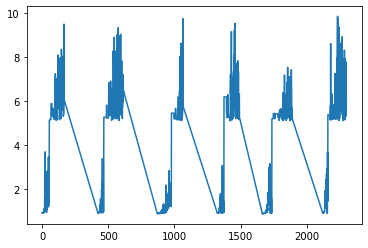

In [42]:
plt.plot(df_t['responsetime'])

In [6]:
df_t.tail()

,total_cpu_util,total_mem_util,responsetime,requests
2294,4.162933,611.728589,5.396289,363.0
2295,4.170137,619.520410,7.804019,364.0
2297,4.160030,607.351603,5.315730,369.0
2298,4.160030,607.351603,5.452060,363.0
2300,4.162305,615.405158,6.125424,366.0


In [7]:
df_t = pd.get_dummies(df_t, prefix='', prefix_sep='')

In [8]:
df_t.shape

(1072, 4)

In [9]:
train_dataset = df_t.sample(frac=0.8, random_state=0)
val_dataset = df_t.drop(train_dataset.index)
test_dataset = df_ttest

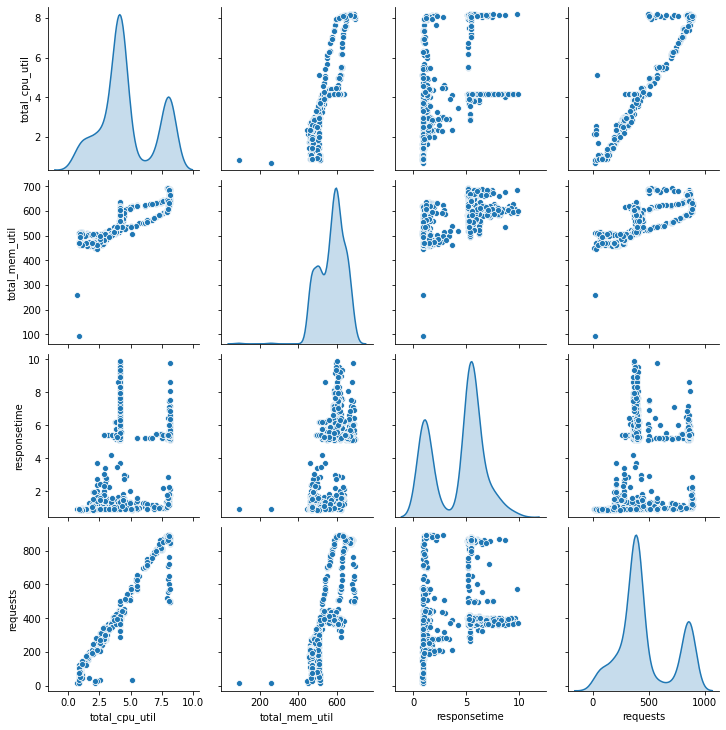

In [10]:
sns.pairplot(train_dataset[['total_cpu_util', 'total_mem_util', 'responsetime', 'requests']], diag_kind='kde')

In [11]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
total_cpu_util,858.0,4.705053,2.169241,0.698756,3.851160,4.169857,6.813509,8.180700
total_mem_util,858.0,574.354674,65.235581,90.926165,521.115802,585.346867,619.901952,694.369087
responsetime,858.0,4.272740,2.379667,0.860624,1.339352,5.261273,5.687480,9.873274
requests,858.0,469.513986,241.579087,14.000000,363.000000,396.000000,651.750000,893.000000


In [12]:
train_features = train_dataset.copy()
val_features = val_dataset.copy()
test_features = test_dataset.copy()

In [13]:
train_features.head()

,total_cpu_util,total_mem_util,responsetime,requests
2162,2.875681,498.111283,5.379598,298.0
529,4.161817,600.513331,5.330744,395.0
968,8.084667,633.448243,1.415241,887.0
1375,3.752223,508.172698,6.196599,386.0
954,8.043127,619.145011,1.232698,887.0


In [14]:
train_labels = train_features.pop('requests')
val_labels = val_features.pop('requests')
test_labels = test_features.pop('requests')

In [15]:
train_labels.head()

2162    298.0
529     395.0
968     887.0
1375    386.0
954     887.0
Name: requests, dtype: float64

In [16]:
normalizer = preprocessing.Normalization()

In [17]:
normalizer.adapt(np.array(train_features))

In [18]:
print(normalizer.mean.numpy())

[  4.705 574.355   4.273]


## Linear Regression

In [19]:
input = np.array(train_features[['total_cpu_util', 'total_mem_util', 'responsetime']])

input_normalizer = preprocessing.Normalization(input_shape=[3,])
input_normalizer.adapt(input)

In [20]:
model = tf.keras.Sequential([
    input_normalizer,
    layers.Dense(units=1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 3)                 7         
_________________________________________________________________
dense (Dense)                (None, 1)                 4         
Total params: 11
Trainable params: 4
Non-trainable params: 7
_________________________________________________________________


In [21]:
model.predict(test_features)

array([[-0.305],
       [-0.239],
       [ 0.633],
       [ 0.632],
       [ 0.552],
       [ 0.512],
       [ 0.495],
       [ 0.495],
       [ 0.565],
       [ 0.567],
       [ 0.369],
       [ 0.368],
       [ 0.36 ],
       [ 0.358],
       [ 0.327],
       [ 0.325],
       [ 0.318],
       [ 0.318],
       [ 0.301],
       [ 0.302],
       [ 0.276],
       [ 0.351],
       [ 0.37 ],
       [ 0.348],
       [ 0.178],
       [ 0.06 ],
       [-0.058],
       [-0.059],
       [ 0.14 ],
       [ 0.142],
       [ 0.274],
       [ 0.272],
       [ 0.308],
       [ 0.311],
       [ 0.324],
       [ 0.323],
       [ 0.33 ],
       [ 0.334],
       [ 0.341],
       [ 0.345],
       [ 0.381],
       [ 0.495],
       [ 0.396],
       [ 0.639],
       [ 0.472],
       [ 0.472],
       [ 0.383],
       [ 0.383],
       [ 0.545],
       [ 0.545],
       [ 0.764],
       [ 0.764],
       [ 0.846],
       [ 0.846],
       [ 0.826],
       [ 0.826],
       [ 0.832],
       [ 0.832],
       [ 0.81 

In [22]:
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [23]:
%%time
history = model.fit(
    train_features[['total_cpu_util', 'total_mem_util', 'responsetime']], train_labels,
    epochs=1000,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 36.6 s, sys: 5.12 s, total: 41.8 s
Wall time: 28.4 s


In [24]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
995,22.635212,23.968918,995
996,22.647789,24.011667,996
997,22.629967,23.995995,997
998,22.657352,23.986574,998
999,22.622255,23.995827,999


In [25]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 500])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

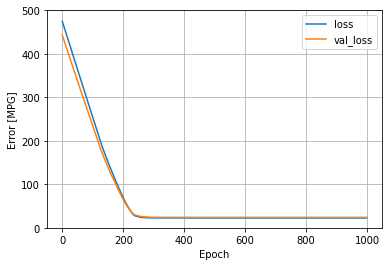

In [26]:
plot_loss(history)

In [27]:
test_results = {}

test_results['model'] = model.evaluate(
    val_features[['total_cpu_util', 'total_mem_util', 'responsetime']],
    val_labels, verbose=0)

In [28]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [29]:
dnn_model = build_and_compile_model(input_normalizer)

In [30]:
dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 3)                 7         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 4,488
Trainable params: 4,481
Non-trainable params: 7
_________________________________________________________________


In [31]:
%%time
history = dnn_model.fit(
    train_features[['total_cpu_util', 'total_mem_util', 'responsetime']], train_labels,
    validation_split=0.2,
    verbose=0, epochs=5000)

CPU times: user 4min 30s, sys: 41.1 s, total: 5min 11s
Wall time: 3min 26s


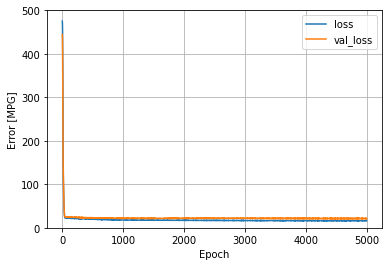

In [32]:
plot_loss(history)

In [33]:
test_results['dnn_model'] = dnn_model.evaluate(
    val_features[['total_cpu_util', 'total_mem_util', 'responsetime']], val_labels,
    verbose=0)

In [34]:
pd.DataFrame(test_results, index=['requests']).T

,requests
model,21.094536
dnn_model,17.010506


## Make Predictions

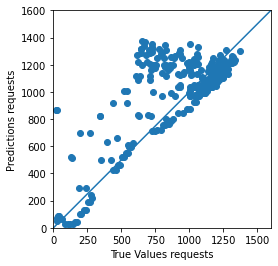

In [35]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values requests')
plt.ylabel('Predictions requests')
lims = [0, 1600]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [36]:
from sklearn.metrics import r2_score
R = r2_score(test_labels, test_predictions)
print ('R² :',R)

R² : 0.4519048240065353


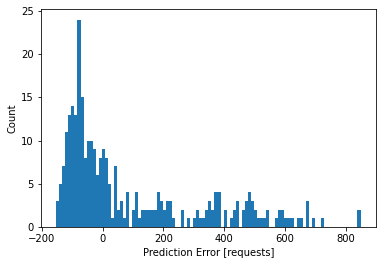

In [37]:
error = test_predictions - test_labels
plt.hist(error, bins=100)
plt.xlabel('Prediction Error [requests]')
_ = plt.ylabel('Count')